<a href="https://colab.research.google.com/github/itochs/Dig-CoLa_test/blob/main/Dig_CoLa_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stress majorization

80 80
79 79
False


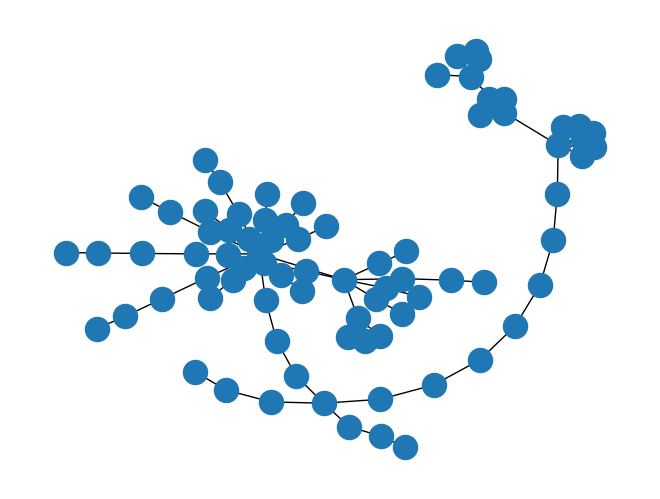

In [131]:
import json
from pprint import pprint
with open("/content/drive/MyDrive/zemi_4/zemi/master/data.json") as f:
  data = json.load(f)

# pprint(data)
nodes = [i+1 for i in range(len(data["nodes"]))]
print(len(data["nodes"]), len(nodes))
# nodes = [1,2,3]
n = len(nodes)


links = [[d["source"]+1, d["target"]+1] for d in data["links"]]
# pprint(data["links"])
# pprint(links)
print(len(data["links"]), len(links))
# links=[[1,2],[1,3]]

# n*n
sigmas = [[0]*n]*n
for i,j in links:
  sigmas[i-1][j-1] = 1

dist = warshall_floyd(sigmas)
# dist = dist[1:, 1:]

from scipy.sparse.linalg import cg
import numpy as np


# stress_majorization
# dimension
d = 2
# 座標の初期値はランダム
Z = np.random.rand(n,d)
Z[0] = (0,0)
# 
alpha = 2
weights = weights_of_normalization_constant(alpha, dist)
# print(weights)
Lw = weight_laplacian(weights)
# print(Lw)
# 終了する閾値
eps = 0.000_01
now_stress = stress(Z,dist,weights)
new_stress = 0.5*now_stress

def delta_stress(now,new):
  return (now-new) / now
print(np.all(np.linalg.eigvals(Lw[1:,1:]) > 0))
while True:
  Lz = z_laplacian(weights, dist, Z)
  for a in range(d):
    # Ax = b
    Z[1:, a] =  cg(Lw[1:,1:],(Lz@Z[:, a])[1:])[0]
  
  new_stress = stress(Z,dist,weights)
  if delta_stress(now_stress, new_stress) < eps:
    break
  now_stress = new_stress
  # break

# print(Z)

import networkx as nx
G = nx.Graph()

for node in nodes:
  G.add_node(node)
  G.nodes[node]["pos"] = Z[node-1]

for link in links:
  G.add_edge(*link)

nx.draw(G)


## 3.1 The stress function

In [96]:
# 全体のstress
def stress(X: list[list], dist: list[list], weights):
  """
  Returns: 全体のストレス
  """
  # dist: graph-theoretical distance
  #   d_{ij}: the length of the shortest path connecting i and j
  #   Cohen -> the linear-network distance
  #     because: better convey any clustered structure in the graph.
  # weight: normalization constant
  #   w_{ij} = d_{ij}^{ -1 * alpha }
  #   Kamada ans Kawai -> alpha = 2
  #   Cohen -> alpha = 0 and 1

  stress_sum = 0
  for i in range(len(X)):
    for j in range(i+1,len(X)):
      mag = vector_magnitude(
          sub_vector(X[i], X[j])
        )
      stress_sum += weights[i][j] * (mag - dist[i][j])*(mag - dist[i][j])
  return stress_sum


In [116]:
import array
from math import pow
import numpy as np

def weights_of_normalization_constant(alpha, dist: list[list]):
  """
  Returns: あるiからjのnormalization_constant
  dist: 二頂点間の最短経路の長さ，到達不可ならfloat('inf')
  """
  n = len(dist)
  weights = [[0 for _ in range(n)] for _ in range(n)]
  for i,di in enumerate(dist):
    for j,dij in enumerate(di):
      if dij == float('inf'):
        continue
      weights[i][j] = 0 if dij < 0.000_01 else pow(dij,-alpha)
  
  return np.array(weights)


In [59]:
from math import sqrt
def vector_magnitude(X: list):
  """
  Returns: ベクトルの大きさ
  X = [] -> return 0
  """
  dist = 0
  for x in X:
    dist += x**2
  
  return sqrt(dist)

assert abs(vector_magnitude([]) - 0) <= 0.0000001, "vector_magnitude"
assert abs(vector_magnitude([1,1]) - sqrt(2)) <= 0.0000001, "vector_magnitude"
assert abs(vector_magnitude([1,2,3]) - sqrt(14)) <= 0.0000001, "vector_magnitude"


In [88]:
def sub_vector(a:list, b:list) -> list | None:
  """
  Return: vector of (a - b) or None
  aとbの長さが違うとNone
  aとbのどちらかが空配列ならNone
  """
  if len(a) != len(b):
    return None
  if len(a) == 0 or len(b) == 0:
    return None
  
  sub = [None]*len(a)
  for i, (ai, bi) in enumerate(zip(a,b)):
    sub[i] = ai-bi
  
  return sub

assert sub_vector([], [1,2]) == None, "sub_vector false"
assert sub_vector([1,2], []) == None, "sub_vector false"
assert sub_vector([], []) == None, "sub_vector false"
assert sub_vector([1,2], [1,2]) == [0,0], "sub_vector false"
assert sub_vector([1,2], [2,1]) == [-1,1], "sub_vector false"
assert sub_vector([1,2,3], [1,2]) == None, "sub_vector length error"

In [84]:
import numpy as np


def warshall_floyd(edge_dist:list[list]) -> list[list]:
  """
  Returns: n頂点のグラフの，任意の二頂点間の最短経路の長さを返す

  edge_dist: ある頂点からある頂点へ移動するときのコスト
  到達できない場合は float('inf') が入る
  """
  n = len(edge_dist)
  dist = [[float('inf') for _ in range(n)] for _ in range(n)]
  # 初期値
  for i in range(n):
    for j in range(n):
      if i==j:
        dist[i][j] = 0
        continue
      
      if edge_dist[i][j] is None:
        continue 
      dist[i][j] = edge_dist[i][j]
  
  # pprint(dist)

  for k in range(n):
    for i in range(n):
      for j in range(n):
      # d[i][j]が最短経路になっているか確認する
      # i -> jの経路長よりも，iからkを中継してjに行った方が近いならそれに更新する
        if dist[i][k] + dist[k][j] < dist[i][j]:
          dist[i][j] = dist[i][k] + dist[k][j]
  
  return np.array(dist)

## 3.2 Stress majorization

In [109]:
import numpy as np

def weight_laplacian(weights):
  L = [[-w for w in ws] for ws in weights]
  w_row_sums = [sum(wjs) for wjs in zip(*weights)]
  for i in range(len(L)):
      L[i][i] = w_row_sums[i] - weights[i][i]
  return np.array(L)

A = np.array([[1, 2, 3], [2, 5, 6], [3, 6, 10]])
LA = weight_laplacian(A)
assert np.all(np.linalg.eigvals(LA[1:,1:]) > 0), "err"

In [67]:
import numpy as np


def z_laplacian(weights: list[list], dist: list[list], Z:list[list]):
  """
  Z: 頂点数n，d次元として，n*d．座標の配列
  """
  n = len(Z)
  Lz = [[0 for _ in range(n)] for _ in range(n)]
  float_eps = 0.000_000_1
  for i in range(n):
    for j in range(n):
      if i == j:
        continue
      
      mag = vector_magnitude(
          sub_vector(Z[i], Z[j])  
      )
      invmag = 0 if mag <= float_eps else 1/mag
      Lz[i][j] = -1*weights[i][j]*dist[i][j]*invmag
  
  Lz_row_sums = [sum(row) for row in zip(*Lz)]
  for i in range(n):
    Lz[i][i] = -Lz_row_sums[i]
  
  return np.array(Lz)


In [64]:
import numpy as np

def Fz(weights, dist, X_, Lw_, Lz_, Z_):
  n = len(X)
  d = len(X[0])

  X = np.array(X_)
  Lw = np.array(Lw_)
  Lz = np.array(Lz_)
  Z = np.array(Z_)
  
  wdd = 0
  for i in range(n):
    for j in range(i+1,n):
      wdd += weights[i][j]*dist[i][j]*dist[i][j]
  
  sm = 0
  for a in range(d):
    Xa = X[:,a]
    Za = Z[:,a]
    sm += Xa.T@Lw@Xa - 2*Xa.T@Lz@Za

  return wdd + sm

## 3.3 Hierarchy energy

In [1]:
def hierarchy_energy(ys: list, sigma: list[list[int]], links:list[int,int]):
  """
  ys: y座標の列ベクトル
  links: 辺
  """
  energy = 0
  n = len(links)
  for i,j in links:
    # yiとyjの高さの差と，sigmaを比較
    h = ys[i] - ys[j] - sigma[i][j]
    energy += h*h
  
  return energy


In [2]:
import numpy as np

def get_new_y(deg, ys, sigma, links):
  n = len(ys)
  links_d:list[int, int] = {i+1: [] for i in range(n)}
  for i,j in links:
    links_d[i].append(j)
  new_y = np.array([0 for i in range(n)])
  
  for i in range(n):
    sm = 0
    for j in links_d[i]:
      sm += ys[j] + sigma[i][j]
      sm += ys[j] - sigma[j][i]
    new_y[i] = sm / deg[i]
  
  return new_y

In [6]:
def degree(links, n) -> dict[int,int]:
  deg = {i+1:0 for i in range(n)}
  
  for k in range(1,n+1):
    for i,j in links:
      if i == k or j == k:
        deg[k] += 1
  
  return deg

degree_test_links = [
    [1,2],
    [1,3],
    [2,3],
    [3,4],
    [4,2]
]
assert degree(degree_test_links, 4) == {1:2,2:3,3:3,4:2}

## 4.1 Hierarchy as constraints

In [21]:
def partition_to_levels(ys):
  n = len(ys)
  alpha = 0.1
  beta = 0.01
  y_star = {i+1:ys[i] for i in range(n)}
  vs = np.array(
      sorted(
          y_star.items(), key=lambda x: x[1],
          reverse=True
      )
  )[:,0]
  # print(vs)
  eps = max(
      beta,
      alpha*(sum([y_star[vs[i]] - y_star[vs[i+1]] for i in range(n-1)]))/(n-1)
  )

  k = 0
  L:list[set] = [set()]
  for i in range(n-1):
    L[k].add(vs[i])
    if y_star[vs[i]] - y_star[vs[i+1]] > eps:
      k += 1
      L.append(set())
  L[k].add(vs[-1])
  return L
  

p2l_test_ys = [
    5,3,1,4,2
]
assert partition_to_levels([5,3,1,4,2]) == [{1},{4},{2},{5},{3}]
assert partition_to_levels([1,1,1,1,1]) == [{1,2,3,4,5}]
assert partition_to_levels([1,1,1,8,1,1]) == [{4},{1,2,3,5,6}]